Data loaded and preprocessed successfully.
X_train shape: (1600, 20)
y_train shape: (1600, 4)
X_val shape: (400, 20)
y_val shape: (400, 4)
Number of classes: 4
Unique labels: [0. 1. 2. 3.]
Starting MCMC sampling for 5000 iterations (plus 1000 burn-in steps)...
Iteration 1000/6000 completed. Current Log Posterior: -5802.8652
Iteration 2000/6000 completed. Current Log Posterior: -2576.4998
Iteration 3000/6000 completed. Current Log Posterior: -1664.5774
Iteration 4000/6000 completed. Current Log Posterior: -1410.8434
Iteration 5000/6000 completed. Current Log Posterior: -1299.7162
Iteration 6000/6000 completed. Current Log Posterior: -1239.8221
MCMC sampling finished.
Total number of sampled weights/biases (after burn-in): 5000

Making predictions on validation set using sampled networks...

Validation Accuracy: 74.75%


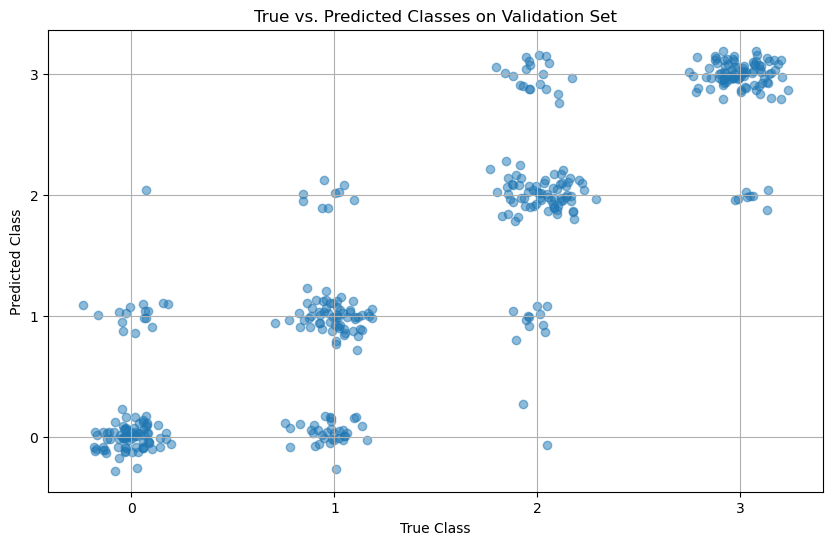

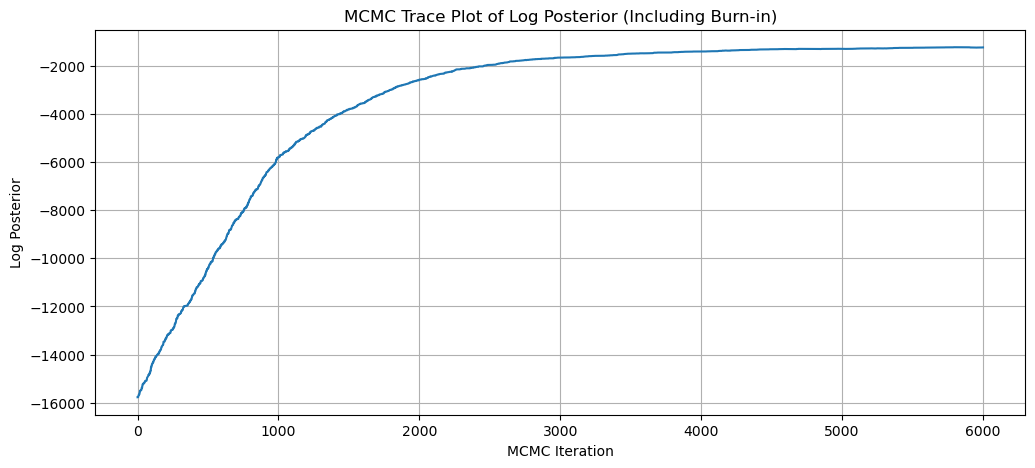

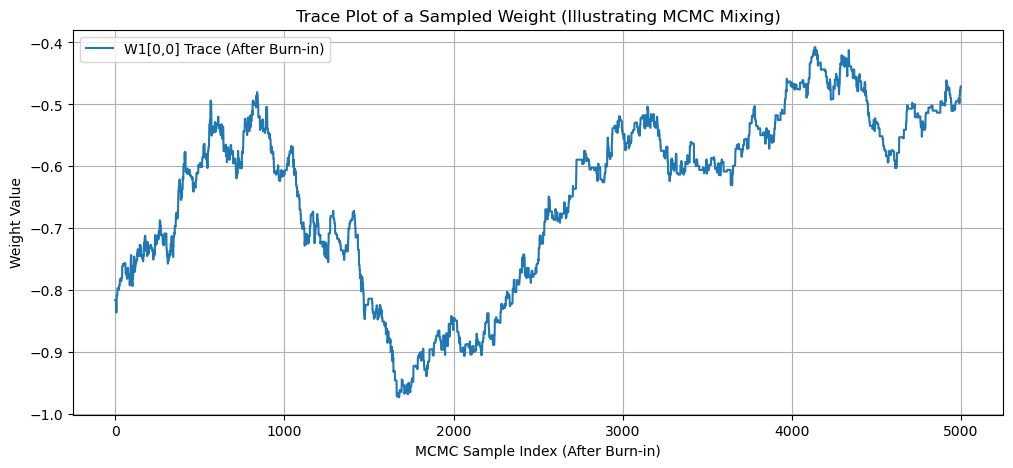

In [7]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from io import StringIO

# --- Data Loading and Preprocessing ---
def load_and_preprocess_data(file_path):
    """
    Loads data from a CSV file path, preprocesses features (scaling),
    and one-hot encodes the target variable.
    Splits data into training and validation sets.
    """
    # Load the entire dataset
    data = np.genfromtxt(file_path, delimiter=',', skip_header=1)

    # Separate features (X) and target (y_raw)
    X = data[:, :-1]  # All columns except the last one are features
    y_raw = data[:, -1] # The last column is the target variable

    # Normalize features (mean 0, std 1)
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    # Handle cases where standard deviation is zero (constant features)
    X_std[X_std == 0] = 1
    X_scaled = (X - X_mean) / X_std

    # One-hot encode target variable
    # Map raw labels to contiguous integers (0, 1, 2, ...)
    unique_labels = np.unique(y_raw)
    label_to_int = {label: i for i, label in enumerate(unique_labels)}
    y_int = np.array([label_to_int[label] for label in y_raw])

    num_classes = len(unique_labels)
    y_one_hot = np.eye(num_classes)[y_int.astype(int)]

    # Split data into training and validation sets
    np.random.seed(42) # For reproducibility
    train_ratio = 0.8
    num_samples = X.shape[0]
    indices = np.random.permutation(num_samples)
    train_size = int(train_ratio * num_samples)
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]

    X_train, y_train = X_scaled[train_indices], y_one_hot[train_indices]
    X_val, y_val = X_scaled[val_indices], y_one_hot[val_indices]
    y_val_raw = y_int[val_indices] # Keep raw integer labels for evaluation/plotting

    return X_train, y_train, X_val, y_val, y_val_raw, num_classes, unique_labels

# --- Neural Network Components ---
def sigmoid(x):
    """Sigmoid activation function."""
    return 1 / (1 + np.exp(-x))

def relu(x):
    """ReLU activation function."""
    return np.maximum(0, x)

def softmax(x):
    """Softmax activation function for output layer numerical stability."""
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

def feed_forward(X, weights, biases, hidden_activation='relu'):
    """
    Performs a forward pass through the neural network.
    Assumes a single hidden layer.
    """
    # Hidden layer calculation
    h1_output = np.dot(X, weights[0]) + biases[0]
    if hidden_activation == 'relu':
        h1_activated = relu(h1_output)
    elif hidden_activation == 'sigmoid':
        h1_activated = sigmoid(h1_output)
    else:
        raise ValueError("Unsupported hidden activation. Choose 'relu' or 'sigmoid'.")

    # Output layer calculation
    output_layer_input = np.dot(h1_activated, weights[1]) + biases[1]
    predictions = softmax(output_layer_input)
    return predictions

# --- Bayesian Components ---
def log_likelihood(y_true, y_pred, epsilon=1e-10):
    """
    Calculates the log-likelihood (Categorical Cross-Entropy) for classification.
    y_true should be one-hot encoded.
    y_pred should be probabilities from softmax.
    """
    # Adding a small epsilon for numerical stability to prevent log(0)
    return np.sum(y_true * np.log(y_pred + epsilon))

def log_prior(weights, biases, prior_std):
    """
    Calculates the log-prior probability for all weights and biases.
    Assumes a Gaussian prior with mean 0 and given standard deviation.
    """
    log_p = 0
    # Sum log PDF for all weights
    for w in weights:
        log_p += np.sum(stats.norm.logpdf(w, loc=0, scale=prior_std))
    # Sum log PDF for all biases
    for b in biases:
        log_p += np.sum(stats.norm.logpdf(b, loc=0, scale=prior_std))
    return log_p

def log_posterior(X, y_true, weights, biases, prior_std, hidden_activation='relu'):
    """
    Calculates the log-posterior probability (log-likelihood + log-prior).
    """
    y_pred = feed_forward(X, weights, biases, hidden_activation)
    ll = log_likelihood(y_true, y_pred)
    lp = log_prior(weights, biases, prior_std)
    return ll + lp

# --- MCMC Sampler ---
def metropolis_hastings(X_data, y_data, input_dim, hidden_dim, output_dim,
                        num_samples, proposal_std, prior_std, hidden_activation='relu',
                        num_burnin=1000):
    """
    Implements the Metropolis-Hastings MCMC algorithm to sample NN weights and biases.

    Args:
        X_data (np.array): Training features.
        y_data (np.array): Training labels (one-hot encoded).
        input_dim (int): Number of input features.
        hidden_dim (int): Number of neurons in the hidden layer.
        output_dim (int): Number of output classes.
        num_samples (int): Number of MCMC samples to collect after burn-in.
        proposal_std (float): Standard deviation for the Gaussian proposal distribution.
        prior_std (float): Standard deviation for the Gaussian prior distribution.
        hidden_activation (str): Activation function for hidden layer ('relu' or 'sigmoid').
        num_burnin (int): Number of initial samples to discard (burn-in period).

    Returns:
        tuple: (list of sampled weights, list of sampled biases, list of log posterior history)
    """
    # Initialize weights and biases randomly from a standard normal distribution
    # weights[0]: input to hidden layer (input_dim x hidden_dim)
    # biases[0]: hidden layer biases (hidden_dim)
    # weights[1]: hidden to output layer (hidden_dim x output_dim)
    # biases[1]: output layer biases (output_dim)
    current_weights = [
        np.random.randn(input_dim, hidden_dim),
        np.random.randn(hidden_dim, output_dim)
    ]
    current_biases = [
        np.random.randn(hidden_dim),
        np.random.randn(output_dim)
    ]

    sampled_weights = []
    sampled_biases = []
    log_posterior_history = [] # To track the log posterior for convergence plots

    # Calculate initial log posterior
    current_log_post = log_posterior(X_data, y_data, current_weights, current_biases, prior_std, hidden_activation)
    log_posterior_history.append(current_log_post)

    print(f"Starting MCMC sampling for {num_samples} iterations (plus {num_burnin} burn-in steps)...")

    # Run MCMC iterations
    for i in range(num_samples + num_burnin):
        # Propose new weights and biases by adding Gaussian noise
        # This is a random walk Metropolis-Hastings
        proposed_weights = [w + np.random.normal(0, proposal_std, w.shape) for w in current_weights]
        proposed_biases = [b + np.random.normal(0, proposal_std, b.shape) for b in current_biases]

        # Calculate the log posterior for the proposed state
        proposed_log_post = log_posterior(X_data, y_data, proposed_weights, proposed_biases, prior_std, hidden_activation)

        # Calculate the acceptance ratio (alpha)
        # alpha = min(1, exp(log_posterior_proposed - log_posterior_current))
        acceptance_ratio = np.exp(proposed_log_post - current_log_post)

        # Accept or reject the proposed state
        if np.random.rand() < acceptance_ratio:
            current_weights = proposed_weights
            current_biases = proposed_biases
            current_log_post = proposed_log_post
        
        # Store log posterior for plotting (even during burn-in to see the initial phase)
        log_posterior_history.append(current_log_post)

        # Store samples only after the burn-in period
        if i >= num_burnin:
            sampled_weights.append([w.copy() for w in current_weights])
            sampled_biases.append([b.copy() for b in current_biases])
        
        if (i + 1) % 1000 == 0:
            print(f"Iteration {i + 1}/{num_samples + num_burnin} completed. Current Log Posterior: {current_log_post:.4f}")

    print("MCMC sampling finished.")
    return sampled_weights, sampled_biases, log_posterior_history

# --- Main Execution ---
if __name__ == '__main__':
    # Define the path to your CSV file
    csv_file_path = 'train.csv' # Assumes train.csv is in the current working directory

    # Load and preprocess data
    try:
        X_train, y_train, X_val, y_val, y_val_raw, num_classes, unique_labels = load_and_preprocess_data(csv_file_path)
        print("Data loaded and preprocessed successfully.")
    except FileNotFoundError:
        print(f"Error: The file '{csv_file_path}' was not found.")
        print("Please ensure 'train.csv' is in the correct directory.")
        exit()
    except Exception as e:
        print(f"An error occurred during data loading or preprocessing: {e}")
        exit()

    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_val shape: {X_val.shape}")
    print(f"y_val shape: {y_val.shape}")
    print(f"Number of classes: {num_classes}")
    print(f"Unique labels: {unique_labels}")

    # Model Parameters
    input_dim = X_train.shape[1]
    hidden_dim = 20 # Number of neurons in the hidden layer, can be tuned
    output_dim = num_classes

    # MCMC Parameters
    num_samples_mcmc = 5000  # Number of MCMC samples to collect after burn-in
    num_burnin_mcmc = 1000   # Number of initial samples to discard
    proposal_std_mcmc = 0.01 # Standard deviation for proposal distribution (tune this!)
                             # A smaller value leads to smaller steps and potentially
                             # higher acceptance, but slower exploration.
    prior_std_mcmc = 1.0     # Standard deviation for Gaussian prior on weights/biases

    # Run MCMC sampling
    sampled_weights, sampled_biases, log_posterior_trace = metropolis_hastings(
        X_train, y_train, input_dim, hidden_dim, output_dim,
        num_samples=num_samples_mcmc, proposal_std=proposal_std_mcmc, prior_std=prior_std_mcmc,
        hidden_activation='relu', # Can be 'sigmoid'
        num_burnin=num_burnin_mcmc
    )

    print(f"Total number of sampled weights/biases (after burn-in): {len(sampled_weights)}")

    # --- Prediction on Validation Set ---
    print("\nMaking predictions on validation set using sampled networks...")
    all_predictions_prob = []
    # For each set of sampled weights and biases, make a prediction
    for i in range(len(sampled_weights)):
        current_preds = feed_forward(X_val, sampled_weights[i], sampled_biases[i], hidden_activation='relu')
        all_predictions_prob.append(current_preds)

    # Average the predicted probabilities from all sampled networks
    avg_predictions_prob = np.mean(np.array(all_predictions_prob), axis=0)
    
    # Get the class with the highest average probability for each sample
    predicted_classes = np.argmax(avg_predictions_prob, axis=1)

    # --- Evaluation ---
    # y_val_raw contains the true integer labels for the validation set
    accuracy = np.mean(predicted_classes == y_val_raw) * 100

    print(f"\nValidation Accuracy: {accuracy:.2f}%")

    # --- Plotting Results ---

    # Plot 1: True vs Predicted Classes on Validation Set
    plt.figure(figsize=(10, 6))
    # Add small random jitter to points for better visualization of overlaps
    plt.scatter(y_val_raw + np.random.normal(0, 0.1, len(y_val_raw)),
                predicted_classes + np.random.normal(0, 0.1, len(predicted_classes)),
                alpha=0.5)
    plt.xlabel("True Class")
    plt.ylabel("Predicted Class")
    plt.title("True vs. Predicted Classes on Validation Set")
    # Set ticks to correspond to the actual class labels
    plt.xticks(np.arange(num_classes), labels=unique_labels.astype(int))
    plt.yticks(np.arange(num_classes), labels=unique_labels.astype(int))
    plt.grid(True)
    plt.show()

    # Plot 2: MCMC Trace Plot of Log Posterior
    # This plot helps visualize the convergence of the MCMC chain.
    plt.figure(figsize=(12, 5))
    plt.plot(log_posterior_trace)
    plt.xlabel("MCMC Iteration")
    plt.ylabel("Log Posterior")
    plt.title("MCMC Trace Plot of Log Posterior (Including Burn-in)")
    plt.grid(True)
    plt.show()

    # Plot 3: Trace Plot of a Specific Sampled Weight
    # This plot helps assess the mixing and convergence of individual parameters.
    if len(sampled_weights) > 0:
        plt.figure(figsize=(12, 5))
        # Plot the trace of the first weight from the first layer
        plt.plot([sw[0][0,0] for sw in sampled_weights], label='W1[0,0] Trace (After Burn-in)')
        plt.xlabel("MCMC Sample Index (After Burn-in)")
        plt.ylabel("Weight Value")
        plt.title("Trace Plot of a Sampled Weight (Illustrating MCMC Mixing)")
        plt.grid(True)
        plt.legend()
        plt.show()


Data loaded and preprocessed successfully.
X_train shape: (1600, 20)
y_train shape: (1600, 4)
X_val shape: (400, 20)
y_val shape: (400, 4)
Number of classes: 4
Unique labels: [0. 1. 2. 3.]
Starting MCMC sampling for 10000 iterations (plus 2000 burn-in steps)...
Iteration 1000/12000 completed. Current Log Posterior: -5837.8082
Iteration 2000/12000 completed. Current Log Posterior: -2632.6486
Iteration 3000/12000 completed. Current Log Posterior: -1704.3238
Iteration 4000/12000 completed. Current Log Posterior: -1447.2068
Iteration 5000/12000 completed. Current Log Posterior: -1327.0453
Iteration 6000/12000 completed. Current Log Posterior: -1254.3245
Iteration 7000/12000 completed. Current Log Posterior: -1204.9957
Iteration 8000/12000 completed. Current Log Posterior: -1184.4166
Iteration 9000/12000 completed. Current Log Posterior: -1137.2651
Iteration 10000/12000 completed. Current Log Posterior: -1119.5589
Iteration 11000/12000 completed. Current Log Posterior: -1108.2322
Iteration 

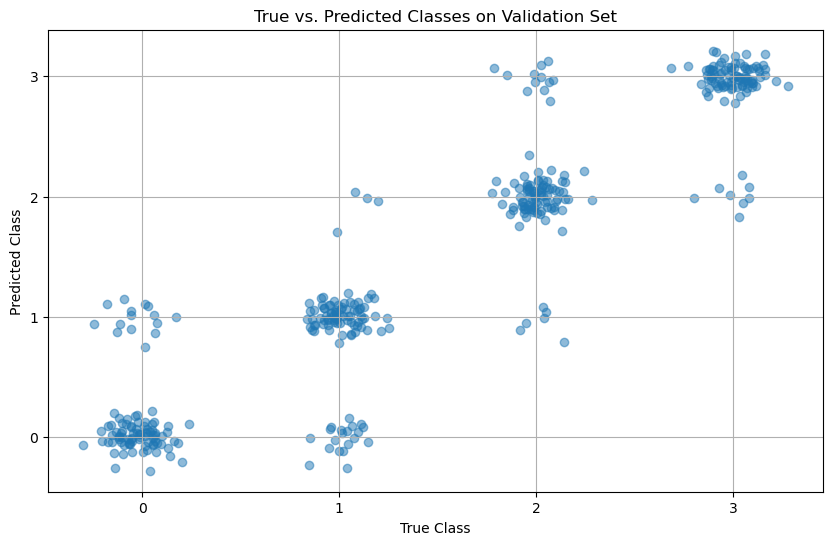

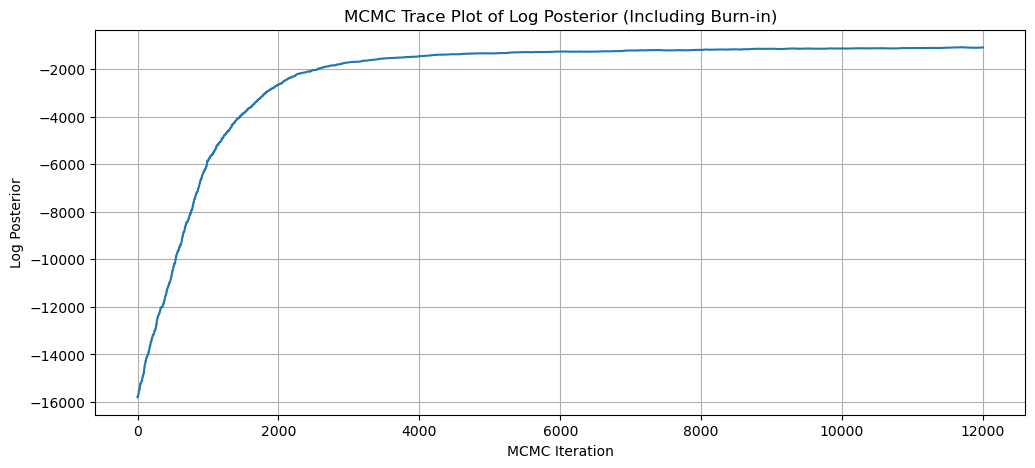

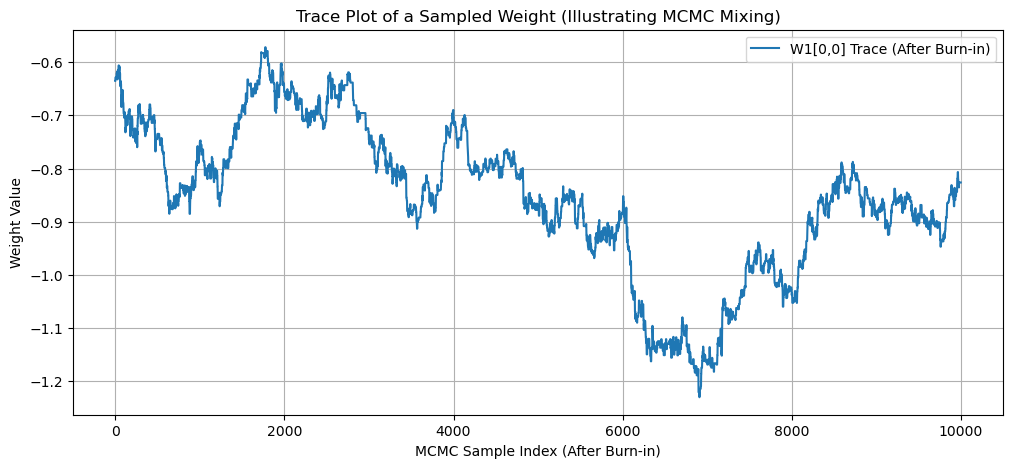

In [8]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from io import StringIO

# --- Data Loading and Preprocessing ---
def load_and_preprocess_data(file_path):
    """
    Loads data from a CSV file path, preprocesses features (scaling),
    and one-hot encodes the target variable.
    Splits data into training and validation sets.
    """
    # Load the entire dataset
    data = np.genfromtxt(file_path, delimiter=',', skip_header=1)

    # Separate features (X) and target (y_raw)
    X = data[:, :-1]  # All columns except the last one are features
    y_raw = data[:, -1] # The last column is the target variable

    # Normalize features (mean 0, std 1)
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    # Handle cases where standard deviation is zero (constant features)
    X_std[X_std == 0] = 1
    X_scaled = (X - X_mean) / X_std

    # One-hot encode target variable
    # Map raw labels to contiguous integers (0, 1, 2, ...)
    unique_labels = np.unique(y_raw)
    label_to_int = {label: i for i, label in enumerate(unique_labels)}
    y_int = np.array([label_to_int[label] for label in y_raw])

    num_classes = len(unique_labels)
    y_one_hot = np.eye(num_classes)[y_int.astype(int)]

    # Split data into training and validation sets
    np.random.seed(42) # For reproducibility
    train_ratio = 0.8
    num_samples = X.shape[0]
    indices = np.random.permutation(num_samples)
    train_size = int(train_ratio * num_samples)
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]

    X_train, y_train = X_scaled[train_indices], y_one_hot[train_indices]
    X_val, y_val = X_scaled[val_indices], y_one_hot[val_indices]
    y_val_raw = y_int[val_indices] # Keep raw integer labels for evaluation/plotting

    return X_train, y_train, X_val, y_val, y_val_raw, num_classes, unique_labels

# --- Neural Network Components ---
def sigmoid(x):
    """Sigmoid activation function."""
    return 1 / (1 + np.exp(-x))

def relu(x):
    """ReLU activation function."""
    return np.maximum(0, x)

def softmax(x):
    """Softmax activation function for output layer numerical stability."""
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

def feed_forward(X, weights, biases, hidden_activation='relu'):
    """
    Performs a forward pass through the neural network.
    Assumes a single hidden layer.
    """
    # Hidden layer calculation
    h1_output = np.dot(X, weights[0]) + biases[0]
    if hidden_activation == 'relu':
        h1_activated = relu(h1_output)
    elif hidden_activation == 'sigmoid':
        h1_activated = sigmoid(h1_output)
    else:
        raise ValueError("Unsupported hidden activation. Choose 'relu' or 'sigmoid'.")

    # Output layer calculation
    output_layer_input = np.dot(h1_activated, weights[1]) + biases[1]
    predictions = softmax(output_layer_input)
    return predictions

# --- Bayesian Components ---
def log_likelihood(y_true, y_pred, epsilon=1e-10):
    """
    Calculates the log-likelihood (Categorical Cross-Entropy) for classification.
    y_true should be one-hot encoded.
    y_pred should be probabilities from softmax.
    """
    # Adding a small epsilon for numerical stability to prevent log(0)
    return np.sum(y_true * np.log(y_pred + epsilon))

def log_prior(weights, biases, prior_scale): # Renamed prior_std to prior_scale for clarity with Laplace
    """
    Calculates the log-prior probability for all weights and biases.
    Assumes a Laplace prior with mean 0 and given scale parameter.
    """
    log_p = 0
    # Sum log PDF for all weights using Laplace distribution
    for w in weights:
        log_p += np.sum(stats.laplace.logpdf(w, loc=0, scale=prior_scale))
    # Sum log PDF for all biases using Laplace distribution
    for b in biases:
        log_p += np.sum(stats.laplace.logpdf(b, loc=0, scale=prior_scale))
    return log_p

def log_posterior(X, y_true, weights, biases, prior_scale, hidden_activation='relu'): # Updated parameter name
    """
    Calculates the log-posterior probability (log-likelihood + log-prior).
    """
    y_pred = feed_forward(X, weights, biases, hidden_activation)
    ll = log_likelihood(y_true, y_pred)
    lp = log_prior(weights, biases, prior_scale) # Updated parameter name
    return ll + lp

# --- MCMC Sampler ---
def metropolis_hastings(X_data, y_data, input_dim, hidden_dim, output_dim,
                        num_samples, proposal_std, prior_scale, hidden_activation='relu', # Updated parameter name
                        num_burnin=1000):
    """
    Implements the Metropolis-Hastings MCMC algorithm to sample NN weights and biases.

    Args:
        X_data (np.array): Training features.
        y_data (np.array): Training labels (one-hot encoded).
        input_dim (int): Number of input features.
        hidden_dim (int): Number of neurons in the hidden layer.
        output_dim (int): Number of output classes.
        num_samples (int): Number of MCMC samples to collect after burn-in.
        proposal_std (float): Standard deviation for the Gaussian proposal distribution.
        prior_scale (float): Scale parameter for the Laplace prior distribution. # Updated description
        hidden_activation (str): Activation function for hidden layer ('relu' or 'sigmoid').
        num_burnin (int): Number of initial samples to discard (burn-in period).

    Returns:
        tuple: (list of sampled weights, list of sampled biases, list of log posterior history)
    """
    # Initialize weights and biases randomly from a standard normal distribution
    # weights[0]: input to hidden layer (input_dim x hidden_dim)
    # biases[0]: hidden layer biases (hidden_dim)
    # weights[1]: hidden to output layer (hidden_dim x output_dim)
    # biases[1]: output layer biases (output_dim)
    current_weights = [
        np.random.randn(input_dim, hidden_dim),
        np.random.randn(hidden_dim, output_dim)
    ]
    current_biases = [
        np.random.randn(hidden_dim),
        np.random.randn(output_dim)
    ]

    sampled_weights = []
    sampled_biases = []
    log_posterior_history = [] # To track the log posterior for convergence plots

    # Calculate initial log posterior
    current_log_post = log_posterior(X_data, y_data, current_weights, current_biases, prior_scale, hidden_activation) # Updated parameter name
    log_posterior_history.append(current_log_post)

    print(f"Starting MCMC sampling for {num_samples} iterations (plus {num_burnin} burn-in steps)...")

    # Run MCMC iterations
    for i in range(num_samples + num_burnin):
        # Propose new weights and biases by adding Gaussian noise
        # This is a random walk Metropolis-Hastings
        proposed_weights = [w + np.random.normal(0, proposal_std, w.shape) for w in current_weights]
        proposed_biases = [b + np.random.normal(0, proposal_std, b.shape) for b in current_biases]

        # Calculate the log posterior for the proposed state
        proposed_log_post = log_posterior(X_data, y_data, proposed_weights, proposed_biases, prior_scale, hidden_activation) # Updated parameter name

        # Calculate the acceptance ratio (alpha)
        # alpha = min(1, exp(log_posterior_proposed - log_posterior_current))
        acceptance_ratio = np.exp(proposed_log_post - current_log_post)

        # Accept or reject the proposed state
        if np.random.rand() < acceptance_ratio:
            current_weights = proposed_weights
            current_biases = proposed_biases
            current_log_post = proposed_log_post
        
        # Store log posterior for plotting (even during burn-in to see the initial phase)
        log_posterior_history.append(current_log_post)

        # Store samples only after the burn-in period
        if i >= num_burnin:
            sampled_weights.append([w.copy() for w in current_weights])
            sampled_biases.append([b.copy() for b in current_biases])
        
        if (i + 1) % 1000 == 0:
            print(f"Iteration {i + 1}/{num_samples + num_burnin} completed. Current Log Posterior: {current_log_post:.4f}")

    print("MCMC sampling finished.")
    return sampled_weights, sampled_biases, log_posterior_history

# --- Main Execution ---
if __name__ == '__main__':
    # Define the path to your CSV file
    csv_file_path = 'train.csv' # Assumes train.csv is in the current working directory

    # Load and preprocess data
    try:
        X_train, y_train, X_val, y_val, y_val_raw, num_classes, unique_labels = load_and_preprocess_data(csv_file_path)
        print("Data loaded and preprocessed successfully.")
    except FileNotFoundError:
        print(f"Error: The file '{csv_file_path}' was not found.")
        print("Please ensure 'train.csv' is in the correct directory.")
        exit()
    except Exception as e:
        print(f"An error occurred during data loading or preprocessing: {e}")
        exit()

    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_val shape: {X_val.shape}")
    print(f"y_val shape: {y_val.shape}")
    print(f"Number of classes: {num_classes}")
    print(f"Unique labels: {unique_labels}")

    # Model Parameters
    input_dim = X_train.shape[1]
    hidden_dim = 20 # Number of neurons in the hidden layer, can be tuned
    output_dim = num_classes

    # MCMC Parameters
    num_samples_mcmc = 10000  # Number of MCMC samples to collect after burn-in
    num_burnin_mcmc = 2000   # Number of initial samples to discard
    proposal_std_mcmc = 0.01 # Standard deviation for proposal distribution (tune this!)
                             # A smaller value leads to smaller steps and potentially
                             # higher acceptance, but slower exploration.
    prior_scale_mcmc = 1.0   # Scale parameter for Laplace prior on weights/biases (formerly prior_std_mcmc)

    # Run MCMC sampling
    sampled_weights, sampled_biases, log_posterior_trace = metropolis_hastings(
        X_train, y_train, input_dim, hidden_dim, output_dim,
        num_samples=num_samples_mcmc, proposal_std=proposal_std_mcmc, prior_scale=prior_scale_mcmc, # Updated parameter name
        hidden_activation='relu', # Can be 'sigmoid'
        num_burnin=num_burnin_mcmc
    )

    print(f"Total number of sampled weights/biases (after burn-in): {len(sampled_weights)}")

    # --- Prediction on Validation Set ---
    print("\nMaking predictions on validation set using sampled networks...")
    all_predictions_prob = []
    # For each set of sampled weights and biases, make a prediction
    for i in range(len(sampled_weights)):
        current_preds = feed_forward(X_val, sampled_weights[i], sampled_biases[i], hidden_activation='relu')
        all_predictions_prob.append(current_preds)

    # Average the predicted probabilities from all sampled networks
    avg_predictions_prob = np.mean(np.array(all_predictions_prob), axis=0)
    
    # Get the class with the highest average probability for each sample
    predicted_classes = np.argmax(avg_predictions_prob, axis=1)

    # --- Evaluation ---
    # y_val_raw contains the true integer labels for the validation set
    accuracy = np.mean(predicted_classes == y_val_raw) * 100

    print(f"\nValidation Accuracy: {accuracy:.2f}%")

    # --- Plotting Results ---

    # Plot 1: True vs Predicted Classes on Validation Set
    plt.figure(figsize=(10, 6))
    # Add small random jitter to points for better visualization of overlaps
    plt.scatter(y_val_raw + np.random.normal(0, 0.1, len(y_val_raw)),
                predicted_classes + np.random.normal(0, 0.1, len(predicted_classes)),
                alpha=0.5)
    plt.xlabel("True Class")
    plt.ylabel("Predicted Class")
    plt.title("True vs. Predicted Classes on Validation Set")
    # Set ticks to correspond to the actual class labels
    plt.xticks(np.arange(num_classes), labels=unique_labels.astype(int))
    plt.yticks(np.arange(num_classes), labels=unique_labels.astype(int))
    plt.grid(True)
    plt.show()

    # Plot 2: MCMC Trace Plot of Log Posterior
    # This plot helps visualize the convergence of the MCMC chain.
    plt.figure(figsize=(12, 5))
    plt.plot(log_posterior_trace)
    plt.xlabel("MCMC Iteration")
    plt.ylabel("Log Posterior")
    plt.title("MCMC Trace Plot of Log Posterior (Including Burn-in)")
    plt.grid(True)
    plt.show()

    # Plot 3: Trace Plot of a Specific Sampled Weight
    # This plot helps assess the mixing and convergence of individual parameters.
    if len(sampled_weights) > 0:
        plt.figure(figsize=(12, 5))
        # Plot the trace of the first weight from the first layer
        plt.plot([sw[0][0,0] for sw in sampled_weights], label='W1[0,0] Trace (After Burn-in)')
        plt.xlabel("MCMC Sample Index (After Burn-in)")
        plt.ylabel("Weight Value")
        plt.title("Trace Plot of a Sampled Weight (Illustrating MCMC Mixing)")
        plt.grid(True)
        plt.legend()
        plt.show()


Data loaded and preprocessed successfully.
X_train shape: (1600, 20)
y_train shape: (1600, 4)
X_val shape: (400, 20)
y_val shape: (400, 4)
Number of classes: 4
Unique labels: [0. 1. 2. 3.]
Starting MCMC sampling for 12000 iterations (plus 3000 burn-in steps)...
Iteration 1000/15000 completed. Current Log Posterior: -5892.6116
Iteration 2000/15000 completed. Current Log Posterior: -2704.1592
Iteration 3000/15000 completed. Current Log Posterior: -1767.4726
Iteration 4000/15000 completed. Current Log Posterior: -1495.0209
Iteration 5000/15000 completed. Current Log Posterior: -1372.8808
Iteration 6000/15000 completed. Current Log Posterior: -1259.5033
Iteration 7000/15000 completed. Current Log Posterior: -1201.7768
Iteration 8000/15000 completed. Current Log Posterior: -1161.8793
Iteration 9000/15000 completed. Current Log Posterior: -1126.7270
Iteration 10000/15000 completed. Current Log Posterior: -1094.0795
Iteration 11000/15000 completed. Current Log Posterior: -1081.6918
Iteration 

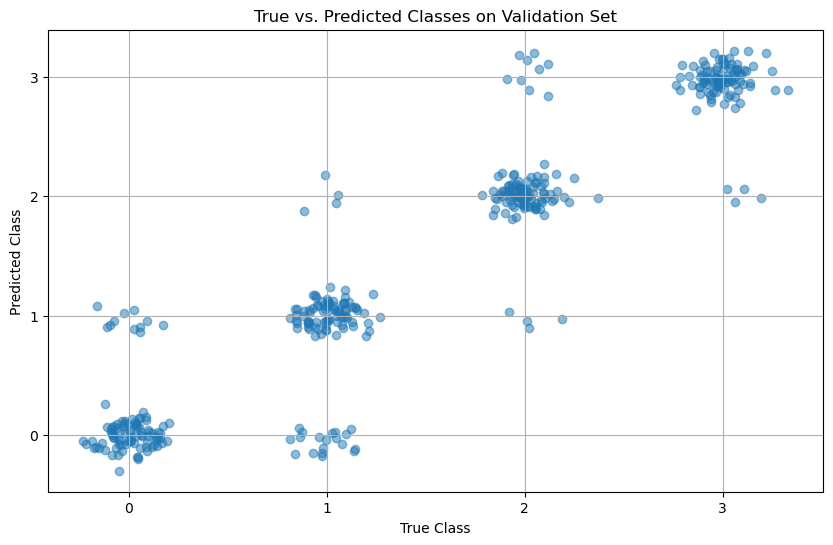

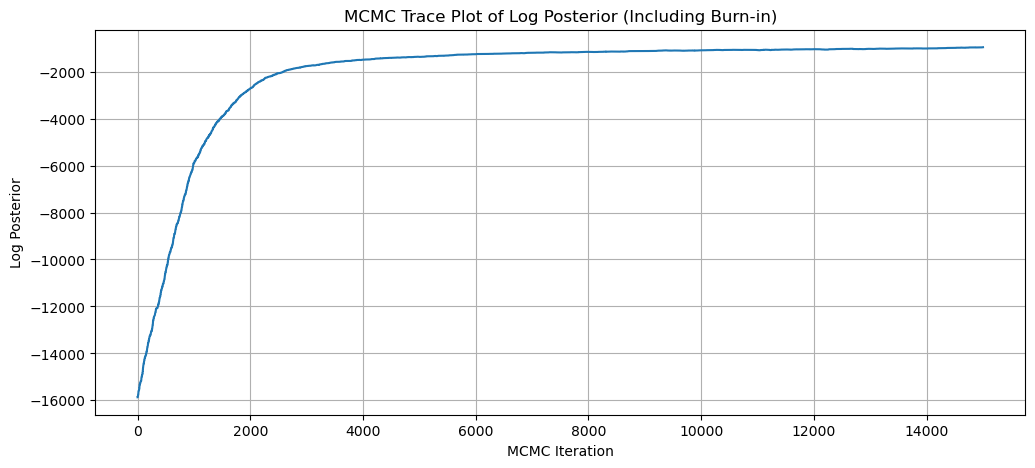

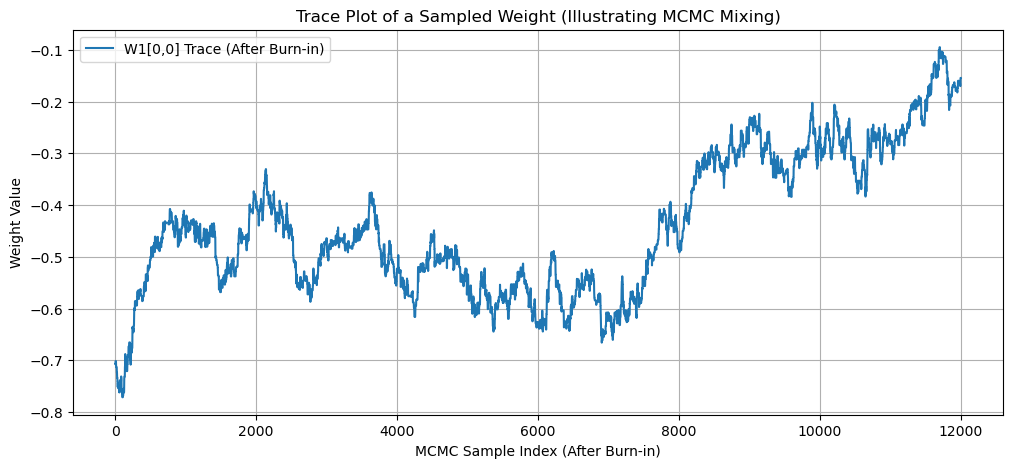

In [9]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from io import StringIO

# --- Data Loading and Preprocessing ---
def load_and_preprocess_data(file_path):
    """
    Loads data from a CSV file path, preprocesses features (scaling),
    and one-hot encodes the target variable.
    Splits data into training and validation sets.
    """
    # Load the entire dataset
    data = np.genfromtxt(file_path, delimiter=',', skip_header=1)

    # Separate features (X) and target (y_raw)
    X = data[:, :-1]  # All columns except the last one are features
    y_raw = data[:, -1] # The last column is the target variable

    # Normalize features (mean 0, std 1)
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    # Handle cases where standard deviation is zero (constant features)
    X_std[X_std == 0] = 1
    X_scaled = (X - X_mean) / X_std

    # One-hot encode target variable
    # Map raw labels to contiguous integers (0, 1, 2, ...)
    unique_labels = np.unique(y_raw)
    label_to_int = {label: i for i, label in enumerate(unique_labels)}
    y_int = np.array([label_to_int[label] for label in y_raw])

    num_classes = len(unique_labels)
    y_one_hot = np.eye(num_classes)[y_int.astype(int)]

    # Split data into training and validation sets
    np.random.seed(42) # For reproducibility
    train_ratio = 0.8
    num_samples = X.shape[0]
    indices = np.random.permutation(num_samples)
    train_size = int(train_ratio * num_samples)
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]

    X_train, y_train = X_scaled[train_indices], y_one_hot[train_indices]
    X_val, y_val = X_scaled[val_indices], y_one_hot[val_indices]
    y_val_raw = y_int[val_indices] # Keep raw integer labels for evaluation/plotting

    return X_train, y_train, X_val, y_val, y_val_raw, num_classes, unique_labels

# --- Neural Network Components ---
def sigmoid(x):
    """Sigmoid activation function."""
    return 1 / (1 + np.exp(-x))

def relu(x):
    """ReLU activation function."""
    return np.maximum(0, x)

def softmax(x):
    """Softmax activation function for output layer numerical stability."""
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

def feed_forward(X, weights, biases, hidden_activation='relu'):
    """
    Performs a forward pass through the neural network.
    Assumes a single hidden layer.
    """
    # Hidden layer calculation
    h1_output = np.dot(X, weights[0]) + biases[0]
    if hidden_activation == 'relu':
        h1_activated = relu(h1_output)
    elif hidden_activation == 'sigmoid':
        h1_activated = sigmoid(h1_output)
    else:
        raise ValueError("Unsupported hidden activation. Choose 'relu' or 'sigmoid'.")

    # Output layer calculation
    output_layer_input = np.dot(h1_activated, weights[1]) + biases[1]
    predictions = softmax(output_layer_input)
    return predictions

# --- Bayesian Components ---
def log_likelihood(y_true, y_pred, epsilon=1e-10):
    """
    Calculates the log-likelihood (Categorical Cross-Entropy) for classification.
    y_true should be one-hot encoded.
    y_pred should be probabilities from softmax.
    """
    # Adding a small epsilon for numerical stability to prevent log(0)
    return np.sum(y_true * np.log(y_pred + epsilon))

def log_prior(weights, biases, prior_scale):
    """
    Calculates the log-prior probability for all weights and biases.
    Assumes a Cauchy prior (Horseshoe-like) with mean 0 and given scale parameter.
    """
    log_p = 0
    # Sum log PDF for all weights using Cauchy distribution
    for w in weights:
        log_p += np.sum(stats.cauchy.logpdf(w, loc=0, scale=prior_scale))
    # Sum log PDF for all biases using Cauchy distribution
    for b in biases:
        log_p += np.sum(stats.cauchy.logpdf(b, loc=0, scale=prior_scale))
    return log_p

def log_posterior(X, y_true, weights, biases, prior_scale, hidden_activation='relu'):
    """
    Calculates the log-posterior probability (log-likelihood + log-prior).
    """
    y_pred = feed_forward(X, weights, biases, hidden_activation)
    ll = log_likelihood(y_true, y_pred)
    lp = log_prior(weights, biases, prior_scale)
    return ll + lp

# --- MCMC Sampler ---
def metropolis_hastings(X_data, y_data, input_dim, hidden_dim, output_dim,
                        num_samples, proposal_std, prior_scale, hidden_activation='relu',
                        num_burnin=1000):
    """
    Implements the Metropolis-Hastings MCMC algorithm to sample NN weights and biases.

    Args:
        X_data (np.array): Training features.
        y_data (np.array): Training labels (one-hot encoded).
        input_dim (int): Number of input features.
        hidden_dim (int): Number of neurons in the hidden layer.
        output_dim (int): Number of output classes.
        num_samples (int): Number of MCMC samples to collect after burn-in.
        proposal_std (float): Standard deviation for the Gaussian proposal distribution.
        prior_scale (float): Scale parameter for the Cauchy prior distribution.
        hidden_activation (str): Activation function for hidden layer ('relu' or 'sigmoid').
        num_burnin (int): Number of initial samples to discard (burn-in period).

    Returns:
        tuple: (list of sampled weights, list of sampled biases, list of log posterior history)
    """
    # Initialize weights and biases randomly from a standard normal distribution
    current_weights = [
        np.random.randn(input_dim, hidden_dim),
        np.random.randn(hidden_dim, output_dim)
    ]
    current_biases = [
        np.random.randn(hidden_dim),
        np.random.randn(output_dim)
    ]

    sampled_weights = []
    sampled_biases = []
    log_posterior_history = [] # To track the log posterior for convergence plots

    # Calculate initial log posterior
    current_log_post = log_posterior(X_data, y_data, current_weights, current_biases, prior_scale, hidden_activation)
    log_posterior_history.append(current_log_post)

    print(f"Starting MCMC sampling for {num_samples} iterations (plus {num_burnin} burn-in steps)...")

    # Run MCMC iterations
    for i in range(num_samples + num_burnin):
        # Propose new weights and biases by adding Gaussian noise
        proposed_weights = [w + np.random.normal(0, proposal_std, w.shape) for w in current_weights]
        proposed_biases = [b + np.random.normal(0, proposal_std, b.shape) for b in current_biases]

        # Calculate the log posterior for the proposed state
        proposed_log_post = log_posterior(X_data, y_data, proposed_weights, proposed_biases, prior_scale, hidden_activation)

        # Calculate the acceptance ratio (alpha)
        acceptance_ratio = np.exp(proposed_log_post - current_log_post)

        # Accept or reject the proposed state
        if np.random.rand() < acceptance_ratio:
            current_weights = proposed_weights
            current_biases = proposed_biases
            current_log_post = proposed_log_post
        
        # Store log posterior for plotting (even during burn-in to see the initial phase)
        log_posterior_history.append(current_log_post)

        # Store samples only after the burn-in period
        if i >= num_burnin:
            sampled_weights.append([w.copy() for w in current_weights])
            sampled_biases.append([b.copy() for b in current_biases])
        
        if (i + 1) % 1000 == 0:
            print(f"Iteration {i + 1}/{num_samples + num_burnin} completed. Current Log Posterior: {current_log_post:.4f}")

    print("MCMC sampling finished.")
    return sampled_weights, sampled_biases, log_posterior_history

# --- Main Execution ---
if __name__ == '__main__':
    # Define the path to your CSV file
    csv_file_path = 'train.csv' # Assumes train.csv is in the current working directory

    # Load and preprocess data
    try:
        X_train, y_train, X_val, y_val, y_val_raw, num_classes, unique_labels = load_and_preprocess_data(csv_file_path)
        print("Data loaded and preprocessed successfully.")
    except FileNotFoundError:
        print(f"Error: The file '{csv_file_path}' was not found.")
        print("Please ensure 'train.csv' is in the correct directory.")
        exit()
    except Exception as e:
        print(f"An error occurred during data loading or preprocessing: {e}")
        exit()

    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_val shape: {X_val.shape}")
    print(f"y_val shape: {y_val.shape}")
    print(f"Number of classes: {num_classes}")
    print(f"Unique labels: {unique_labels}")

    # Model Parameters
    input_dim = X_train.shape[1]
    hidden_dim = 20 # Number of neurons in the hidden layer, can be tuned
    output_dim = num_classes

    # MCMC Parameters
    num_samples_mcmc = 12000  # Number of MCMC samples to collect after burn-in
    num_burnin_mcmc = 3000   # Number of initial samples to discard
    proposal_std_mcmc = 0.01 # Standard deviation for proposal distribution (tune this!)
                             # A smaller value leads to smaller steps and potentially
                             # higher acceptance, but slower exploration.

    # Horseshoe-like Prior Parameters (Cauchy distribution)
    prior_scale_mcmc = 0.5 # Scale parameter for Cauchy prior on weights/biases (tune this!)


    # Run MCMC sampling
    sampled_weights, sampled_biases, log_posterior_trace = metropolis_hastings(
        X_train, y_train, input_dim, hidden_dim, output_dim,
        num_samples=num_samples_mcmc, proposal_std=proposal_std_mcmc, prior_scale=prior_scale_mcmc,
        hidden_activation='relu', # Can be 'sigmoid'
        num_burnin=num_burnin_mcmc
    )

    print(f"Total number of sampled weights/biases (after burn-in): {len(sampled_weights)}")

    # --- Prediction on Validation Set ---
    print("\nMaking predictions on validation set using sampled networks...")
    all_predictions_prob = []
    # For each set of sampled weights and biases, make a prediction
    for i in range(len(sampled_weights)):
        current_preds = feed_forward(X_val, sampled_weights[i], sampled_biases[i], hidden_activation='relu')
        all_predictions_prob.append(current_preds)

    # Average the predicted probabilities from all sampled networks
    avg_predictions_prob = np.mean(np.array(all_predictions_prob), axis=0)
    
    # Get the class with the highest average probability for each sample
    predicted_classes = np.argmax(avg_predictions_prob, axis=1)

    # --- Evaluation ---
    # y_val_raw contains the true integer labels for the validation set
    accuracy = np.mean(predicted_classes == y_val_raw) * 100

    print(f"\nValidation Accuracy: {accuracy:.2f}%")

    # --- Plotting Results ---

    # Plot 1: True vs Predicted Classes on Validation Set
    plt.figure(figsize=(10, 6))
    # Add small random jitter to points for better visualization of overlaps
    plt.scatter(y_val_raw + np.random.normal(0, 0.1, len(y_val_raw)),
                predicted_classes + np.random.normal(0, 0.1, len(predicted_classes)),
                alpha=0.5)
    plt.xlabel("True Class")
    plt.ylabel("Predicted Class")
    plt.title("True vs. Predicted Classes on Validation Set")
    # Set ticks to correspond to the actual class labels
    plt.xticks(np.arange(num_classes), labels=unique_labels.astype(int))
    plt.yticks(np.arange(num_classes), labels=unique_labels.astype(int))
    plt.grid(True)
    plt.show()

    # Plot 2: MCMC Trace Plot of Log Posterior
    # This plot helps visualize the convergence of the MCMC chain.
    plt.figure(figsize=(12, 5))
    plt.plot(log_posterior_trace)
    plt.xlabel("MCMC Iteration")
    plt.ylabel("Log Posterior")
    plt.title("MCMC Trace Plot of Log Posterior (Including Burn-in)")
    plt.grid(True)
    plt.show()

    # Plot 3: Trace Plot of a Specific Sampled Weight
    # This plot helps assess the mixing and convergence of individual parameters.
    if len(sampled_weights) > 0:
        plt.figure(figsize=(12, 5))
        # Plot the trace of the first weight from the first layer
        plt.plot([sw[0][0,0] for sw in sampled_weights], label='W1[0,0] Trace (After Burn-in)')
        plt.xlabel("MCMC Sample Index (After Burn-in)")
        plt.ylabel("Weight Value")
        plt.title("Trace Plot of a Sampled Weight (Illustrating MCMC Mixing)")
        plt.grid(True)
        plt.legend()
        plt.show()


Epoch 0: ELBO = -6428.60, Val Acc = 0.2850
Epoch 10: ELBO = -6536.68, Val Acc = 0.2425
Epoch 20: ELBO = -6466.16, Val Acc = 0.2650
Epoch 30: ELBO = -6310.51, Val Acc = 0.2850
Epoch 40: ELBO = -6391.16, Val Acc = 0.2875
Epoch 50: ELBO = -6583.24, Val Acc = 0.2550
Epoch 60: ELBO = -6632.74, Val Acc = 0.2725
Epoch 70: ELBO = -6433.23, Val Acc = 0.2725
Epoch 80: ELBO = -6389.48, Val Acc = 0.3000
Epoch 90: ELBO = -6477.66, Val Acc = 0.2850
Epoch 100: ELBO = -6306.49, Val Acc = 0.2625
Epoch 110: ELBO = -6422.22, Val Acc = 0.3250
Epoch 120: ELBO = -6130.94, Val Acc = 0.2775
Epoch 130: ELBO = -6167.78, Val Acc = 0.2875
Epoch 140: ELBO = -5969.66, Val Acc = 0.2950
Epoch 150: ELBO = -5947.47, Val Acc = 0.2675
Epoch 160: ELBO = -5897.54, Val Acc = 0.2850
Epoch 170: ELBO = -6000.99, Val Acc = 0.2500
Epoch 180: ELBO = -5740.05, Val Acc = 0.3050
Epoch 190: ELBO = -5989.14, Val Acc = 0.2775

Final Training Accuracy: 0.3025
Final Validation Accuracy: 0.2950


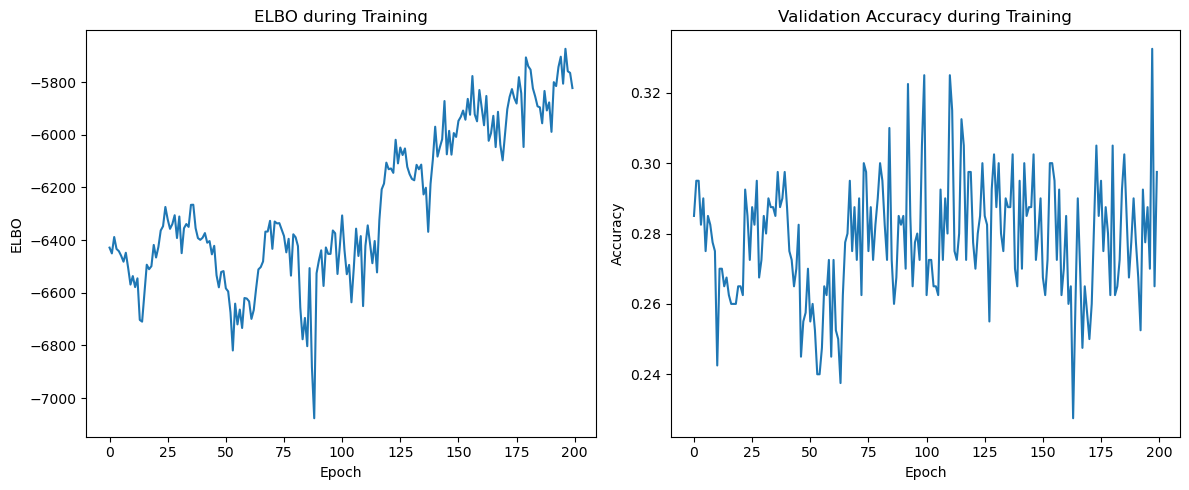

In [18]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class BayesianNeuralNetwork:
    def __init__(self, input_dim, hidden_dim, output_dim):
        # Initialize weights with Xavier/Glorot initialization
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        # Variational parameters for weights (mean and rho)
        self.w1_mu = np.random.randn(input_dim, hidden_dim) * np.sqrt(2./(input_dim + hidden_dim))
        self.w1_rho = np.full((input_dim, hidden_dim), -3.0)
        self.b1_mu = np.zeros((1, hidden_dim))
        self.b1_rho = np.full((1, hidden_dim), -3.0)
        
        self.w2_mu = np.random.randn(hidden_dim, output_dim) * np.sqrt(2./(hidden_dim + output_dim))
        self.w2_rho = np.full((hidden_dim, output_dim), -3.0)
        self.b2_mu = np.zeros((1, output_dim))
        self.b2_rho = np.full((1, output_dim), -3.0)
        
        # Prior parameters
        self.prior_sigma = 1.0  # Standard normal prior
        
        # Training history
        self.elbo_history = []
        self.accuracy_history = []

    def _sigma(self, rho):
        # Softplus transformation with numerical stability
        return np.log1p(np.exp(np.clip(rho, -10, 10))) + 1e-6

    def _sample_weights(self):
        # Sample weights using reparameterization trick
        w1 = self.w1_mu + self._sigma(self.w1_rho) * np.random.randn(*self.w1_mu.shape)
        b1 = self.b1_mu + self._sigma(self.b1_rho) * np.random.randn(*self.b1_mu.shape)
        w2 = self.w2_mu + self._sigma(self.w2_rho) * np.random.randn(*self.w2_mu.shape)
        b2 = self.b2_mu + self._sigma(self.b2_rho) * np.random.randn(*self.b2_mu.shape)
        return w1, b1, w2, b2

    def forward(self, X, num_samples=1):
        # Monte Carlo forward pass
        outputs = []
        for _ in range(num_samples):
            w1, b1, w2, b2 = self._sample_weights()
            
            # Hidden layer with ReLU
            h = np.maximum(0, X @ w1 + b1)
            
            # Output layer with softmax
            logits = h @ w2 + b2
            logits = logits - np.max(logits, axis=1, keepdims=True)  # Numerical stability
            exp_logits = np.exp(logits)
            probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
            outputs.append(probs)
        
        return np.mean(outputs, axis=0)

    def _log_prior(self, w):
        # Log probability under standard normal prior
        return np.sum(stats.norm.logpdf(w, 0, self.prior_sigma))

    def _log_variational(self, w, mu, rho):
        # Log probability under variational distribution
        sigma = self._sigma(rho)
        return np.sum(stats.norm.logpdf(w, mu, sigma))

    def elbo(self, X, y, num_samples=5):
        log_likelihood = 0
        kl_divergence = 0
        
        for _ in range(num_samples):
            # Sample weights
            w1, b1, w2, b2 = self._sample_weights()
            
            # Forward pass
            h = np.maximum(0, X @ w1 + b1)
            logits = h @ w2 + b2
            logits = logits - np.max(logits, axis=1, keepdims=True)
            exp_logits = np.exp(logits)
            probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
            
            # Log likelihood
            log_likelihood += np.sum(y * np.log(probs + 1e-10))
            
            # KL divergence terms
            kl_divergence += (self._log_variational(w1, self.w1_mu, self.w1_rho) - self._log_prior(w1))
            kl_divergence += (self._log_variational(b1, self.b1_mu, self.b1_rho) - self._log_prior(b1))
            kl_divergence += (self._log_variational(w2, self.w2_mu, self.w2_rho) - self._log_prior(w2))
            kl_divergence += (self._log_variational(b2, self.b2_mu, self.b2_rho) - self._log_prior(b2))
        
        # Average over samples
        log_likelihood /= num_samples
        kl_divergence /= num_samples
        
        return log_likelihood - kl_divergence

    def train(self, X_train, y_train, X_val, y_val, epochs=200, batch_size=32, learning_rate=0.01):
        num_batches = int(np.ceil(X_train.shape[0] / batch_size))
        
        for epoch in range(epochs):
            # Shuffle data
            permutation = np.random.permutation(X_train.shape[0])
            X_train_shuffled = X_train[permutation]
            y_train_shuffled = y_train[permutation]
            
            for i in range(num_batches):
                # Get batch
                start = i * batch_size
                end = start + batch_size
                X_batch = X_train_shuffled[start:end]
                y_batch = y_train_shuffled[start:end]
                
                # Compute gradients using finite differences
                eps = 1e-4
                grads = {}
                
                # Store original parameters
                original_params = {
                    'w1_mu': self.w1_mu.copy(),
                    'w1_rho': self.w1_rho.copy(),
                    'b1_mu': self.b1_mu.copy(),
                    'b1_rho': self.b1_rho.copy(),
                    'w2_mu': self.w2_mu.copy(),
                    'w2_rho': self.w2_rho.copy(),
                    'b2_mu': self.b2_mu.copy(),
                    'b2_rho': self.b2_rho.copy()
                }
                
                # Compute ELBO at current point
                current_elbo = self.elbo(X_batch, y_batch)
                
                # Compute gradients for all parameters
                for param in original_params:
                    # Perturb parameter positively
                    setattr(self, param, original_params[param] + eps)
                    elbo_plus = self.elbo(X_batch, y_batch)
                    
                    # Perturb parameter negatively
                    setattr(self, param, original_params[param] - eps)
                    elbo_minus = self.elbo(X_batch, y_batch)
                    
                    # Reset parameter
                    setattr(self, param, original_params[param])
                    
                    # Compute gradient
                    grads[param] = (elbo_plus - elbo_minus) / (2 * eps)
                
                # Update parameters with gradient clipping
                for param in original_params:
                    grad = np.clip(grads[param], -1, 1)  # Gradient clipping
                    current_value = getattr(self, param)
                    setattr(self, param, current_value + learning_rate * grad)
            
            # Compute validation metrics
            val_pred = self.predict(X_val)
            val_acc = accuracy_score(np.argmax(y_val, axis=1), val_pred)
            
            # Store history
            self.accuracy_history.append(val_acc)
            self.elbo_history.append(self.elbo(X_train, y_train))
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch}: ELBO = {self.elbo_history[-1]:.2f}, Val Acc = {val_acc:.4f}")

    def predict(self, X, num_samples=10):
        probs = self.forward(X, num_samples)
        return np.argmax(probs, axis=1)

# Data loading and preprocessing
def load_and_preprocess_data(filename):
    data = np.genfromtxt(filename, delimiter=',', skip_header=1)
    X = data[:, :-1]
    y = data[:, -1].astype(int)
    
    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # One-hot encode labels
    num_classes = len(np.unique(y))
    y_onehot = np.eye(num_classes)[y]
    
    return X, y_onehot, scaler

# Main execution
def main():
    # Load and preprocess data
    X, y_onehot, scaler = load_and_preprocess_data("train.csv")
    
    # Split into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y_onehot, test_size=0.2, random_state=42)
    
    # Model parameters
    input_dim = X_train.shape[1]
    hidden_dim = 64  # Increased hidden units
    output_dim = y_train.shape[1]
    
    # Create and train model
    model = BayesianNeuralNetwork(input_dim, hidden_dim, output_dim)
    model.train(X_train, y_train, X_val, y_val, 
                epochs=200, 
                batch_size=64, 
                learning_rate=0.005)
    
    # Final evaluation
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    
    train_acc = accuracy_score(np.argmax(y_train, axis=1), train_pred)
    val_acc = accuracy_score(np.argmax(y_val, axis=1), val_pred)
    
    print(f"\nFinal Training Accuracy: {train_acc:.4f}")
    print(f"Final Validation Accuracy: {val_acc:.4f}")
    
    # Plot training curves
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(model.elbo_history)
    plt.title("ELBO during Training")
    plt.xlabel("Epoch")
    plt.ylabel("ELBO")
    
    plt.subplot(1, 2, 2)
    plt.plot(model.accuracy_history)
    plt.title("Validation Accuracy during Training")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()